## Loading datasets (UCF50)

In [8]:
import kagglehub

# Download latest version
ucf50_path = kagglehub.dataset_download("pypiahmad/realistic-action-recognition-ucf50")

print("Path to dataset files:", ucf50_path)

Path to dataset files: /kaggle/input/realistic-action-recognition-ucf50


In [3]:
import os

ucf50_path = ucf50_path + "/UCF50"
print("Root path:", ucf50_path)
ucf50_classes = list(os.listdir(ucf50_path))
print("Number of classes: ", len(ucf50_classes))
print("Classes: ", ucf50_classes)

Root path: /kaggle/input/realistic-action-recognition-ucf50/UCF50
Number of classes:  50
Classes:  ['HorseRace', 'VolleyballSpiking', 'Biking', 'TaiChi', 'Punch', 'BreastStroke', 'Billiards', 'PoleVault', 'ThrowDiscus', 'BaseballPitch', 'HorseRiding', 'Mixing', 'HighJump', 'Skijet', 'SkateBoarding', 'MilitaryParade', 'Fencing', 'JugglingBalls', 'Swing', 'RockClimbingIndoor', 'SalsaSpin', 'PlayingTabla', 'Rowing', 'BenchPress', 'PushUps', 'Nunchucks', 'PlayingViolin', 'PullUps', 'PlayingPiano', 'HulaHoop', 'RopeClimbing', 'YoYo', 'TrampolineJumping', 'JumpingJack', 'Drumming', 'GolfSwing', 'PlayingGuitar', 'PizzaTossing', 'Lunges', 'TennisSwing', 'WalkingWithDog', 'Kayaking', 'PommelHorse', 'Basketball', 'JumpRope', 'CleanAndJerk', 'Skiing', 'Diving', 'SoccerJuggling', 'JavelinThrow']


## Implementation

## CODE

In [1]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import multiprocessing as mp

CONFIG = {
     'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
     'teacher_flow_dir': './teacher_flows',
     'img_size': 224,
     'num_frames': 16
}

def process_single_video(path):
    root = Path(CONFIG["dataset_path"])
    save_dir = CONFIG["teacher_flow_dir"]
    os.makedirs(save_dir, exist_ok=True)

    vid_id = path.stem
    last_file = os.path.join(save_dir, f"{vid_id}_{CONFIG['num_frames']-2}.npy")

    # skip already completed video
    if os.path.exists(last_file):
        return "skip"

    # read all frames
    cap = cv2.VideoCapture(str(path))
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (CONFIG["img_size"], CONFIG["img_size"]))
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
    cap.release()

    if len(frames) < 2:
        return "too_short"

    # uniform sampling
    idx = np.linspace(0, len(frames)-1, CONFIG["num_frames"]).astype(int)
    sampled = [frames[i] for i in idx]

    # flow generation
    for t in range(len(sampled) - 1):
        prev = sampled[t]
        curr = sampled[t + 1]

        flow = cv2.calcOpticalFlowFarneback(
            prev, curr, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )

        save_path = os.path.join(save_dir, f"{vid_id}_{t}.npy")
        np.save(save_path, flow.astype(np.float16))

    return "ok"

def generate_teacher_flows_parallel():
    root = Path(CONFIG["dataset_path"])
    save_dir = CONFIG["teacher_flow_dir"]

    if not root.exists():
        print(f"ERROR: dataset path {root} does not exist.")
        return

    #find videos
    video_paths = list(root.glob("*/*.avi"))
    print(f"Found {len(video_paths)} videos.")

    #pool uses all CPU cores
    cpu_count = mp.cpu_count()
    print(f"Using {cpu_count} CPU cores...")

    with mp.Pool(cpu_count) as pool:
        results = list(tqdm(
            pool.imap(process_single_video, video_paths),
            total=len(video_paths),
            desc="Generating Flows (Parallel)"
        ))

    print("Summary:", {r: results.count(r) for r in set(results)})
    print(f"Flows saved to: {save_dir}")

generate_teacher_flows_parallel()

Found 6681 videos.
Using 4 CPU cores...


Generating Flows (Parallel): 100%|██████████| 6681/6681 [16:40<00:00,  6.68it/s]

Summary: {'ok': 6681}
Flows saved to: ./teacher_flows


Comparing Video: v_BenchPress_g07_c03
Video Path: /kaggle/input/realistic-action-recognition-ucf50/UCF50/BenchPress/v_BenchPress_g07_c03.avi


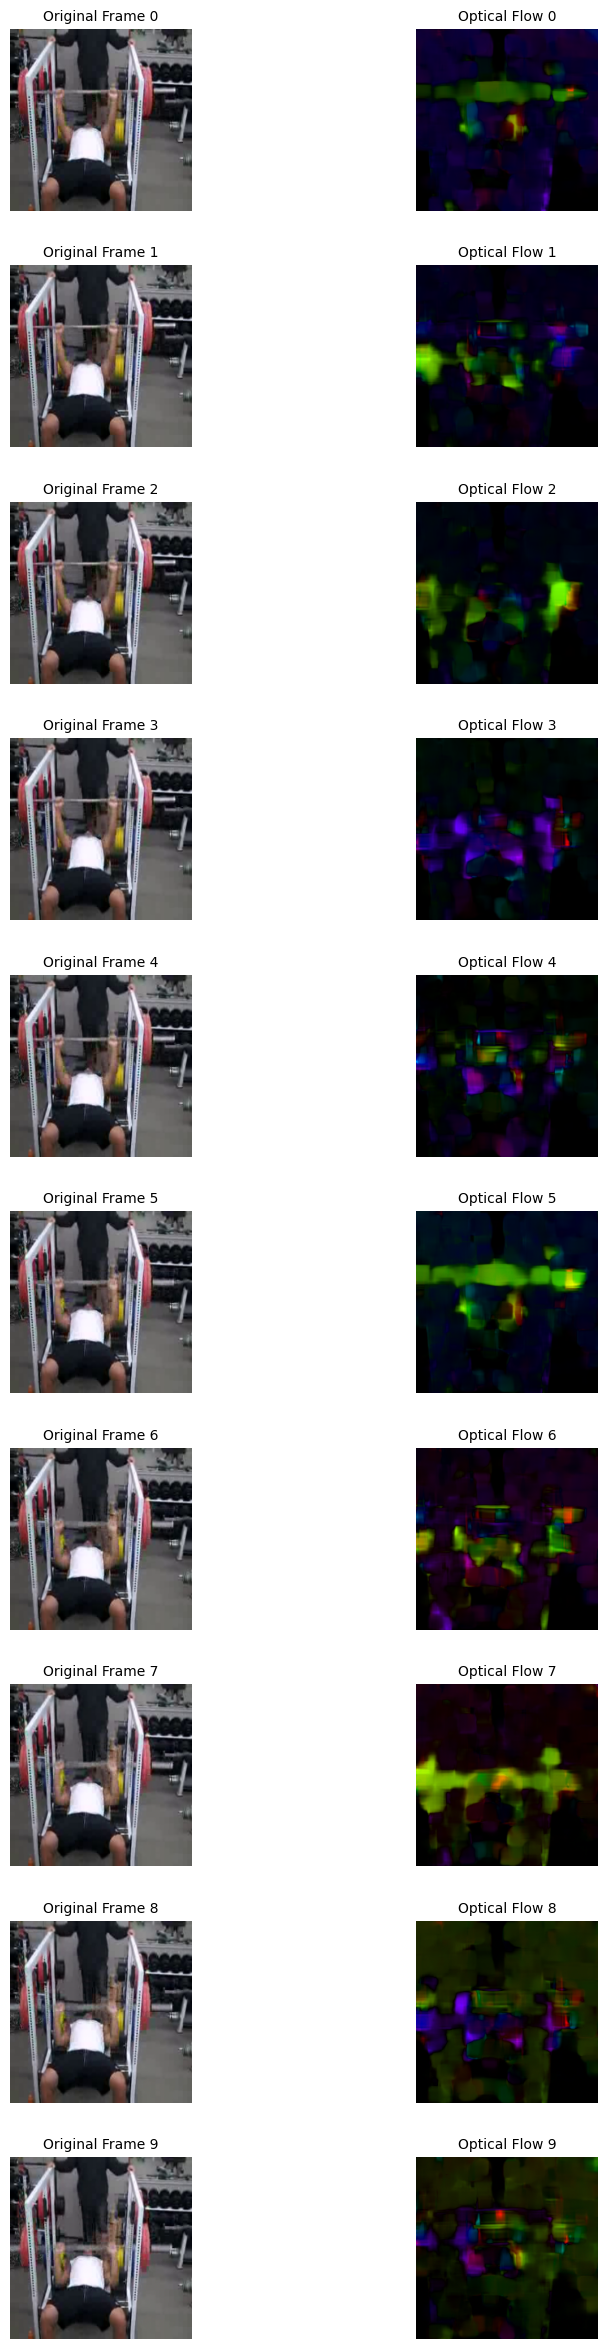

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# config
FLOW_DIR = "/kaggle/working/teacher_flows" 
DATASET_ROOT = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"

def flow_to_rgb(flow):
    if flow is None: return np.zeros((224,224,3), dtype=np.uint8)
    h, w = flow.shape[:2]
    
    flow = flow.astype(np.float32)
    
    #calculate magnitude and angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
    
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2       
    hsv[..., 1] = 255            
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) 
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def find_video_path(vid_id, root_dir):
    try:
        parts = vid_id.split('_')
        if len(parts) >= 2:
            class_name = parts[1]
            vid_path = os.path.join(root_dir, class_name, f"{vid_id}.avi")
            if os.path.exists(vid_path):
                return vid_path
            
    except Exception as e:
        pass

    print(f"Direct path failed, searching for {vid_id}.avi in {root_dir}...")
    for path in Path(root_dir).rglob(f"{vid_id}.avi"):
        return str(path)
        
    return None

def visualize_comparison(vid_id, flow_dir, dataset_root, num_frames=10):
    vid_path = find_video_path(vid_id, dataset_root)
    
    if not vid_path:
        print(f"Could not find original video for ID: {vid_id}")
        return

    print(f"Comparing Video: {vid_id}")
    print(f"Video Path: {vid_path}")

    fig, axes = plt.subplots(num_frames, 2, figsize=(10, 3 * num_frames))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    cap = cv2.VideoCapture(vid_path)
    
    for t in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, t)
        ret, frame_bgr = cap.read()
        
        if ret:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            frame_rgb = cv2.resize(frame_rgb, (224, 224)) # resize to match flow
        else:
            frame_rgb = np.zeros((224, 224, 3), dtype=np.uint8)

        flow_path = os.path.join(flow_dir, f"{vid_id}_{t}.npy")
        if os.path.exists(flow_path):
            try:
                flow = np.load(flow_path)
                flow_rgb = flow_to_rgb(flow)
            except:
                flow_rgb = np.zeros((224, 224, 3), dtype=np.uint8)
        else:
            flow_rgb = np.zeros((224, 224, 3), dtype=np.uint8)

        # original frames on hte left
        axes[t, 0].imshow(frame_rgb)
        axes[t, 0].set_title(f"Original Frame {t}", fontsize=10)
        axes[t, 0].axis('off')

        # optical flow on the right
        axes[t, 1].imshow(flow_rgb)
        axes[t, 1].set_title(f"Optical Flow {t}", fontsize=10)
        axes[t, 1].axis('off')

    cap.release()
    plt.show()

def run_random_comparison():
    if not os.path.exists(FLOW_DIR):
        print("Flow directory not found.")
        return
    
    files = [f for f in os.listdir(FLOW_DIR) if f.endswith('.npy')]
    if not files:
        print("No flow files found.")
        return
        
    random_file = random.choice(files)
    vid_id = random_file.rsplit('_', 1)[0]
    
    visualize_comparison(vid_id, FLOW_DIR, DATASET_ROOT)

run_random_comparison()

Running on: cuda
Selected Video: v_PizzaTossing_g22_c04.avi


Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth


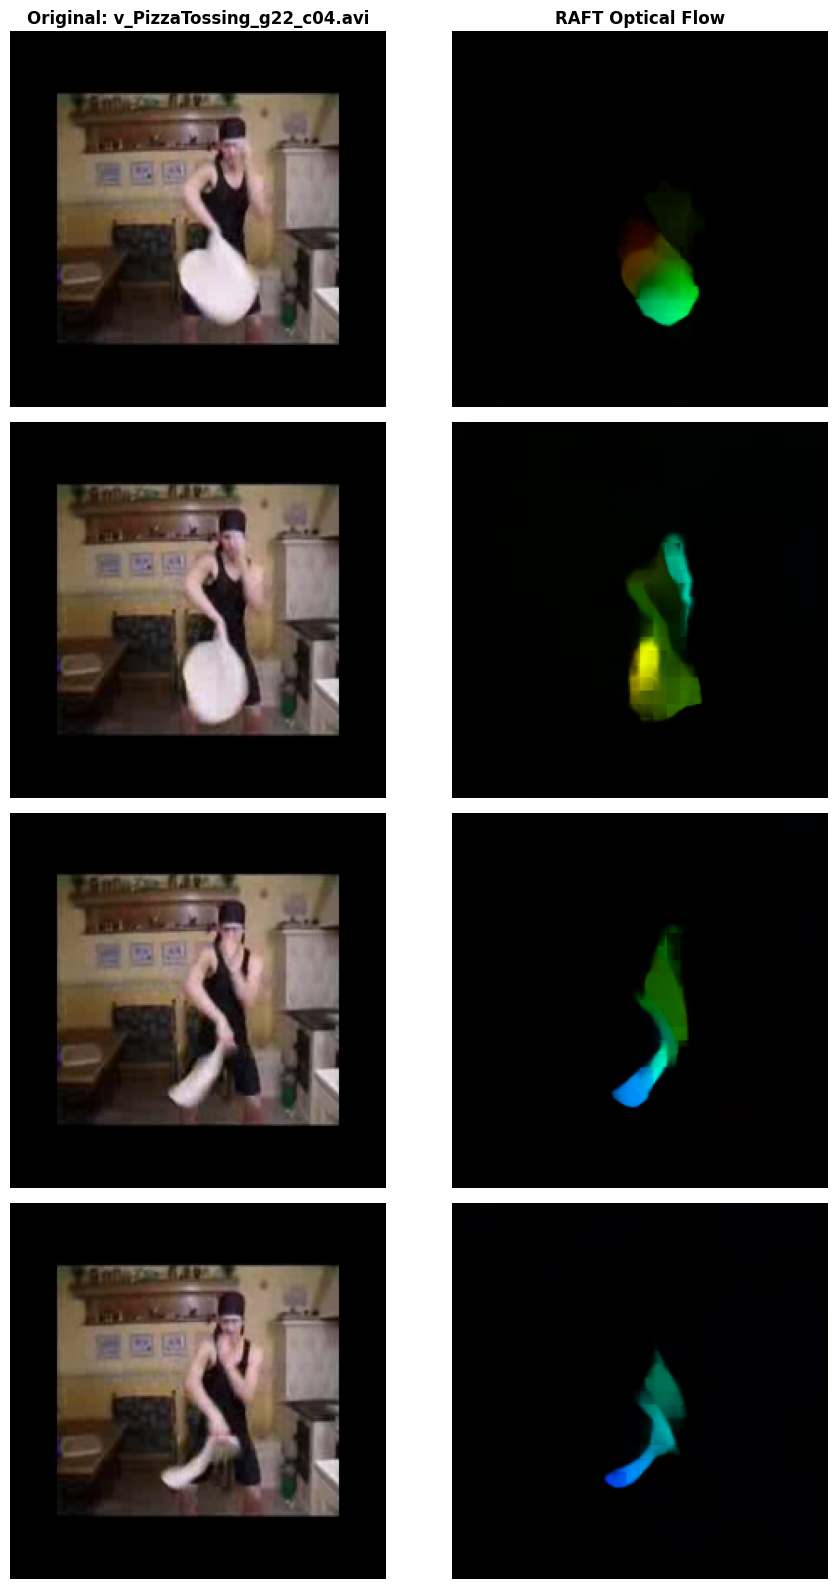

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# config
DATASET_ROOT = '/kaggle/input/realistic-action-recognition-ucf50/UCF50'
IMG_SIZE = 224
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Running on: {DEVICE}")

def load_raft():
    weights = Raft_Large_Weights.DEFAULT
    model = raft_large(weights=weights, progress=False).to(DEVICE)
    model.eval()
    transforms = weights.transforms()
    return model, transforms

def flow_to_rgb(flow):
    if flow is None: return np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
    flow = flow.astype(np.float32)
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
    
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    hsv[..., 0] = ang / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def compute_raft_flow(model, transforms, frame1, frame2):
    img1 = cv2.resize(frame1, (IMG_SIZE, IMG_SIZE))
    img2 = cv2.resize(frame2, (IMG_SIZE, IMG_SIZE))
    
    img1_t = F.to_tensor(img1).unsqueeze(0).to(DEVICE)
    img2_t = F.to_tensor(img2).unsqueeze(0).to(DEVICE)
    
    img1_t, img2_t = transforms(img1_t, img2_t)

    with torch.no_grad():
        list_of_flows = model(img1_t, img2_t)
        predicted_flow = list_of_flows[-1][0]
    return predicted_flow.permute(1, 2, 0).cpu().numpy()

def visualize_single_video_raft(num_frames_to_show=4):
    all_vids = list(Path(DATASET_ROOT).rglob("*.avi"))
    if not all_vids:
        print("No videos found. Check your DATASET_ROOT path.")
        return

    vid_path = str(random.choice(all_vids))
    vid_name = os.path.basename(vid_path)
    print(f"Selected Video: {vid_name}")
    
    model, transforms = load_raft()
    
    cap = cv2.VideoCapture(vid_path)
    frames = []
    while len(frames) < num_frames_to_show + 1:
        ret, frame = cap.read()
        if not ret: break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    
    if len(frames) < 2:
        print("Video is too short.")
        return

    fig, axes = plt.subplots(num_frames_to_show, 2, figsize=(10, 4 * num_frames_to_show))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    axes[0, 0].set_title(f"Original: {vid_name}", fontsize=12, fontweight='bold')
    axes[0, 1].set_title("RAFT Optical Flow", fontsize=12, fontweight='bold')

    for i in range(num_frames_to_show):
        if i >= len(frames) - 1: break
        
        prev = frames[i]
        curr = frames[i+1]
        
        flow = compute_raft_flow(model, transforms, prev, curr)
        flow_vis = flow_to_rgb(flow)
        
        prev_disp = cv2.resize(prev, (IMG_SIZE, IMG_SIZE))
        
        axes[i, 0].imshow(prev_disp)
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(flow_vis)
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# Run it
visualize_single_video_raft()

In [ ]:
# config
import os
import shutil
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import GradScaler, autocast
import torchvision.transforms as transforms
import torchvision.models as models
from einops import rearrange

# config
CONFIG = {
    'dataset_path': '/kaggle/input/realistic-action-recognition-ucf50/UCF50',
    'save_dir': './checkpoints',
    
    'teacher_flow_dir': './teacher_flows', 
    'precompute_teacher': False, 

    'num_frames': 16,        
    'frames_to_select': 8,   
    'img_size': 224,
    'num_classes': 50,

    'batch_size': 16,        
    'accumulation_steps': 1, 
    'lr': 1e-4,
    'weight_decay': 1e-2,
    'num_workers': 4,

    'epochs_mhn_pretrain': 3,
    'epochs_classifier': 6,
    'epochs_finetune': 6,

    'use_teacher_distill': True,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'seed': 42,
    'max_samples': None, 
    
    'lambda_grad': 0.5,
    'beta_flow': 0.5,
    'alpha_sparsity': 0.01,
}

# utils
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def flow_to_rgb(flow_tensor):
    if torch.is_tensor(flow_tensor):
        flow = flow_tensor.detach().cpu().numpy()
    else:
        flow = flow_tensor
    flow = np.transpose(flow, (1, 2, 0)) 
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.uint8)
    hsv[..., 1] = 255 
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# loss functions
def flow_epe_loss(pred, target):
    return torch.norm(pred - target, dim=1).mean()

def flow_grad_loss(pred, target):
    def gradient(x):
        dx = x[:, :, :, 1:] - x[:, :, :, :-1]
        dy = x[:, :, 1:, :] - x[:, :, :-1, :]
        return dx, dy
    pdx, pdy = gradient(pred)
    tdx, tdy = gradient(target)
    return (pdx - tdx).abs().mean() + (pdy - tdy).abs().mean()

def entropy_sparsity_loss(masks):
    eps = 1e-8
    entropy = -torch.sum(masks * torch.log(masks + eps), dim=-1)
    return entropy.mean()

def gumbel_softmax_sample(logits, tau=1.0):
    u = torch.rand_like(logits)
    g = -torch.log(-torch.log(u + 1e-20) + 1e-20)
    return F.softmax((logits + g) / tau, dim=-1)

In [ ]:
# model definitoions
class MotionHallucinationNet(nn.Module):
    def __init__(self, in_ch=6, base_ch=32):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.pool = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch*2, 3, 1, dilation=2, padding=2), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.enc3 = nn.Sequential(nn.Conv2d(base_ch*2, base_ch*4, 3, 1, dilation=4, padding=4), nn.BatchNorm2d(base_ch*4), nn.ReLU(inplace=True))
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec2 = nn.Sequential(nn.Conv2d(base_ch*6, base_ch*2, 3, 1, 1), nn.BatchNorm2d(base_ch*2), nn.ReLU(inplace=True))
        self.dec1 = nn.Sequential(nn.Conv2d(base_ch*3, base_ch, 3, 1, 1), nn.BatchNorm2d(base_ch), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(base_ch, 2, 3, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x); p1 = self.pool(e1)
        e2 = self.enc2(p1); p2 = self.pool(e2)
        e3 = self.enc3(p2)
        d2 = self.dec2(torch.cat([self.up(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))
        return self.final(d1)

class DiffNet_Selector(nn.Module):
    def __init__(self, frames_to_select, use_gumbel=False):
        super().__init__()
        self.K = frames_to_select
        self.use_gumbel = use_gumbel
        mobilenet = models.mobilenet_v2(weights='DEFAULT')
        self.diff_encoder = nn.Sequential(*list(mobilenet.features.children())[:7])
        with torch.no_grad():
            dummy = torch.randn(1,3,CONFIG['img_size'],CONFIG['img_size'])
            feat_ch = self.diff_encoder(dummy).shape[1]
        self.saliency_head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(feat_ch, 1))

    def forward(self, frames, tau=1.0):
        B, T = frames.shape[:2]
        diffs = frames[:,1:] - frames[:,:-1]
        feats = self.diff_encoder(rearrange(diffs, 'b t c h w -> (b t) c h w'))
        logits = self.saliency_head(feats).view(B, T-1)
        logits = torch.cat([logits, torch.zeros(B,1, device=frames.device)], dim=1) 
        
        if self.training:
            if self.use_gumbel:
                masks = torch.stack([gumbel_softmax_sample(logits, tau) for _ in range(self.K)], dim=1)
            else:
                masks = F.softmax(logits, dim=1).unsqueeze(1).repeat(1, self.K, 1)
            return masks, logits
        else:
            _, indices = torch.topk(logits, self.K, dim=1)
            return torch.sort(indices, dim=1)[0], logits

class DS_STT_AFO(nn.Module):
    def __init__(self, num_classes, frames_to_select, use_gumbel=False):
        super().__init__()
        self.selector = DiffNet_Selector(frames_to_select, use_gumbel)
        self.mhn = MotionHallucinationNet()
        
        res_rgb = models.resnet34(weights='DEFAULT')
        res_flow = models.resnet34(weights='DEFAULT')
        self.rgb_enc = nn.Sequential(*list(res_rgb.children())[:-2])
        self.flow_enc = nn.Sequential(*list(res_flow.children())[:-2])
        
        with torch.no_grad():
            w = self.flow_enc[0].weight.mean(1, keepdim=True).repeat(1,2,1,1)
            self.flow_enc[0] = nn.Conv2d(2,64,7,2,3,bias=False)
            try: self.flow_enc[0].weight.copy_(w)
            except: nn.init.kaiming_normal_(self.flow_enc[0].weight)

        self.dim = 512
        self.rgb_proj = nn.Linear(512, self.dim)
        self.flow_proj = nn.Linear(512, self.dim)
        self.cross_attn = nn.MultiheadAttention(self.dim, 8, batch_first=True)
        self.flow_gate = nn.Parameter(torch.zeros(1))
        enc = nn.TransformerEncoderLayer(self.dim, 8, 2048, 0.1, batch_first=True)
        self.transformer = nn.TransformerEncoder(enc, 4)
        self.pos_embed = nn.Parameter(torch.randn(1, frames_to_select, self.dim) * 0.02)
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(self.dim, num_classes))

    def forward(self, x, tau=1.0, return_meta=False):
        B, T, C, H, W = x.shape
        sel_out, sel_logits = self.selector(x, tau)

        if self.training:
            # soft selection
            rgb_k = torch.einsum('btchw,bkt->bkchw', x, sel_out)
            x_next = torch.cat([x[:,1:], x[:,-1:]], dim=1)
            rgb_k_next = torch.einsum('btchw,bkt->bkchw', x_next, sel_out)
        else:
            # hard selection
            idx = sel_out
            batch_idx = torch.arange(B, device=x.device).unsqueeze(1)
            rgb_k = x[batch_idx, idx]
            rgb_k_next = x[batch_idx, torch.clamp(idx+1, max=T-1)]

        pairs = rearrange(torch.cat([rgb_k, rgb_k_next], dim=2), 'b k c h w -> (b k) c h w')
        pred_flow = self.mhn(pairs)

        rgb_in = rearrange(rgb_k, 'b k c h w -> (b k) c h w')
        rgb_feat = self.rgb_proj(F.adaptive_avg_pool2d(self.rgb_enc(rgb_in), (1,1)).flatten(1)).view(B, -1, self.dim)
        
        norm_flow = pred_flow / max(H, W)
        flow_feat = self.flow_proj(F.adaptive_avg_pool2d(self.flow_enc(norm_flow), (1,1)).flatten(1)).view(B, -1, self.dim)

        attn_out = self.cross_attn(rgb_feat, flow_feat, flow_feat)[0]
        fused = rgb_feat + self.flow_gate * attn_out + self.pos_embed
        logits = self.classifier(self.transformer(fused).mean(1))

        if return_meta:
            return logits, {'pred_flow': pred_flow.view(B, -1, 2, H, W), 'sel_logits': sel_logits, 'sel_out': sel_out}
        return logits

In [ ]:
# dataset
class HARDataset(Dataset):
    def __init__(self, root, num_frames, transform=None, max_samples=None):
        self.root = Path(root)
        self.num_frames = num_frames
        self.transform = transform
        self.samples = []
        if self.root.exists():
            classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
            self.cls_map = {c:i for i,c in enumerate(classes)}
            for c in classes:
                for v in (self.root/c).glob('*.avi'):
                    self.samples.append((str(v), self.cls_map[c], v.stem))
        if max_samples: self.samples = self.samples[:max_samples]

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label, vid_id = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while True:
            ret, f = cap.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(f, cv2.COLOR_BGR2RGB)))
        cap.release()
        if not frames:
            frames = [Image.new('RGB', (CONFIG['img_size'], CONFIG['img_size'])) for _ in range(self.num_frames)]
        indices = np.linspace(0, len(frames)-1, self.num_frames).astype(int)
        frames = [frames[i] for i in indices]
        if self.transform:
            frames = [self.transform(f) for f in frames]
        return torch.stack(frames), label, vid_id

# load teacvher flow npy files
def load_soft_teacher_flow_ram_safe(vid_ids, sel_masks, device):
    B, K, T = sel_masks.shape 
    H, W = CONFIG['img_size'], CONFIG['img_size']
    batch = []
    
    for b, vid in enumerate(vid_ids):
        flows = []
        #T-1 because we have 15 flows for 16 frames
        for t in range(T-1):
            p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
            if os.path.exists(p):
                #load OpenCV style (H, W, 2)
                f_np = np.load(p).astype(np.float32)
                
                #convert to Torch (2, H, W)
                f_t = torch.from_numpy(f_np).permute(2,0,1)
                
                # resize if needed bec pytorch expects 4D for interpolate 
                if f_t.shape[-1] != W:
                    f = F.interpolate(f_t.unsqueeze(0), size=(H,W), mode='bilinear', align_corners=False).squeeze(0)
                else:
                    f = f_t
            else:
                f = torch.zeros((2,H,W), dtype=torch.float32)
            flows.append(f)
            
        if not flows: 
            vid_stack = torch.zeros((T-1,2,H,W))
        else: 
            vid_stack = torch.stack(flows) # (15, 2, H, W)
        
        vid_stack = vid_stack.to(device)
        weights = sel_masks[b, :, :-1].to(device).float()
        denom = weights.sum(dim=1, keepdim=True) + 1e-8
        
        # weighted sum: (K, 15) * (15, 2, H, W) -> (K, 2, H, W)
        weighted = torch.einsum('kt, tchw -> kchw', weights/denom, vid_stack)
        batch.append(weighted)
        
    return torch.stack(batch)

In [29]:
# training engine
def train_one_epoch(model, loader, optimizer, scaler, criterion, device, stage):
    model.train()
    total_loss = 0.0; correct = 0; total = 0
    
    for i, (frames, labels, vid_ids) in enumerate(tqdm(loader, desc=f"Train {stage}")):
        frames, labels = frames.to(device), labels.to(device)
        
        with autocast(device_type='cuda' if device == 'cuda' else 'cpu'):
            logits, meta = model(frames, return_meta=True)
            ce = criterion(logits, labels)
            sparsity = entropy_sparsity_loss(meta['sel_out'])
            
            flow_loss = torch.tensor(0., device=device)
            if stage == 'C' and CONFIG['use_teacher_distill']:
                # Load ground truth flows on demand
                teacher = load_soft_teacher_flow_ram_safe(vid_ids, meta['sel_out'], device)
                pred = meta['pred_flow']
                flow_loss = flow_epe_loss(pred, teacher) + CONFIG['lambda_grad'] * flow_grad_loss(pred, teacher)
                
            loss = (ce + CONFIG['alpha_sparsity']*sparsity + CONFIG['beta_flow']*flow_loss) / CONFIG['accumulation_steps']
            
        scaler.scale(loss).backward()
        if (i + 1) % CONFIG['accumulation_steps'] == 0:
            scaler.unscale_(optimizer); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()
            
        total_loss += loss.item() * CONFIG['accumulation_steps']
        correct += (logits.argmax(1) == labels).sum().item(); total += labels.size(0)

    return total_loss/len(loader), 100.*correct/total

def validate_with_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0; correct = 0; total = 0
    with torch.no_grad():
        for frames, labels, _ in tqdm(loader, desc="Validating"):
            frames, labels = frames.to(device), labels.to(device)
            logits = model(frames)
            loss = criterion(logits, labels)
            total_loss += loss.item() * frames.size(0)
            correct += (logits.argmax(1) == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total if total > 0 else 0.0
    acc = 100. * correct / total if total > 0 else 0.0
    print(f"[Val] Loss: {avg_loss:.4f} | Acc: {acc:.2f}%")
    return avg_loss, acc

def run_training_pipeline_full():
    set_seed(CONFIG['seed'])
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']

    # dataset transforms
    tfm = transforms.Compose([
        transforms.Resize((240,240)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.05),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
    ds = HARDataset(CONFIG['dataset_path'], CONFIG['num_frames'], tfm, CONFIG['max_samples'])
    train_sz = int(0.8 * len(ds))
    train_ds, val_ds = random_split(ds, [train_sz, len(ds)-train_sz])
    train_dl = DataLoader(train_ds, CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
    val_dl = DataLoader(val_ds, CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])

    base_model = DS_STT_AFO(len(ds.cls_map), CONFIG['frames_to_select']).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(base_model)
    else:
        print("Using single GPU")
        model = base_model

    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val = -1.0

    # Stage A: MHN Pretrain
    print("\n=== Stage A: MHN Pretrain ===")
    opt_mhn = optim.AdamW(base_model.mhn.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
    
    for ep in range(CONFIG['epochs_mhn_pretrain']):
        base_model.mhn.train()
        total_mhn_loss = 0
        for frames, _, vid_ids in tqdm(train_dl, desc=f"MHN Epoch {ep+1}"):
            frames = frames.to(device)
            t = random.randint(0, CONFIG['num_frames']-2)
            pair = torch.cat([frames[:,t], frames[:,t+1]], dim=1)
            
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                pred = base_model.mhn(pair) 
                
                # load ground truth specific to 't'
                targets = []
                for vid in vid_ids:
                    p = f"{CONFIG['teacher_flow_dir']}/{vid}_{t}.npy"
                    try:
                        # Load (H,W,2) -> Permute (2,H,W)
                        f_np = np.load(p).astype(np.float32)
                        f_t = torch.from_numpy(f_np).permute(2,0,1).float()
                        
                        if f_t.shape[-1] != CONFIG['img_size']:
                             f_t = F.interpolate(f_t.unsqueeze(0), size=(CONFIG['img_size'], CONFIG['img_size']), mode='bilinear', align_corners=False).squeeze(0)
                        targets.append(f_t)
                    except:
                        targets.append(torch.zeros((2, CONFIG['img_size'], CONFIG['img_size'])))
                
                target_batch = torch.stack(targets).to(device)
                loss = flow_epe_loss(pred, target_batch)
            
            scaler.scale(loss).backward()
            scaler.step(opt_mhn); scaler.update(); opt_mhn.zero_grad()
            total_mhn_loss += loss.item()
        print(f"MHN Loss: {total_mhn_loss/len(train_dl):.4f}")

    #Stage B: Warmup
    print("\n=== Stage B: Warmup ===")
    for p in base_model.mhn.parameters(): p.requires_grad = False
    opt = optim.AdamW([p for p in base_model.parameters() if p.requires_grad], lr=CONFIG['lr'])
    
    for ep in range(CONFIG['epochs_classifier']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'B')
        vl, va = validate_with_loss(model, val_dl, criterion, device)
        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")

    # Stage C: Finetune
    print("\n=== Stage C: Finetune ===")
    for p in base_model.mhn.parameters(): p.requires_grad = True
    opt = optim.AdamW(base_model.parameters(), lr=CONFIG['lr']*0.1)
    
    for ep in range(CONFIG['epochs_finetune']):
        tl, ta = train_one_epoch(model, train_dl, opt, scaler, criterion, device, 'C')
        vl, va = validate_with_loss(model, val_dl, criterion, device)
        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta); history['val_acc'].append(va)
        if va > best_val: best_val = va; torch.save(base_model.state_dict(), f"{CONFIG['save_dir']}/best.pth")
        
    return model, val_dl, history

In [35]:
# visualization

def visualize_training_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val', marker='o')
    plt.title('Loss'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val', marker='o')
    plt.title('Accuracy'); plt.legend(); plt.grid(True)
    plt.tight_layout(); 
    plt.show()
    plt.savefig("training_curves.png")

def visualize_5_hallucinations(model, dataloader, device):
    model.eval()
    count = 0; max_count = 5
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(10, 15))
    with torch.no_grad():
        for frames, _, _ in dataloader:
            frames = frames.to(device)
            # Use DataParallel model
            _, meta = model(frames, return_meta=True)
            
            pred_flows = meta['pred_flow']
            sel_out = meta['sel_out']
            
            for b in range(frames.shape[0]):
                if count >= max_count: break
                idx_t = sel_out[b, 0].item() 
                rgb = frames[b, idx_t].permute(1,2,0).cpu().numpy()
                rgb = std * rgb + mean; rgb = np.clip(rgb, 0, 1)
                
                flow_tensor = pred_flows[b, 0] 
                rgb_flow = flow_to_rgb(flow_tensor)
                
                plt.subplot(5, 2, count*2 + 1)
                plt.imshow(rgb); plt.title(f"Sample {count+1}: Selected"); plt.axis('off')
                plt.subplot(5, 2, count*2 + 2)
                plt.imshow(rgb_flow); plt.title(f"Sample {count+1}: Hallucinated Flow"); plt.axis('off')
                count += 1
            if count >= max_count: break
    plt.tight_layout(); 
    plt.show()

Using 2 GPUs!

=== Stage A: MHN Pretrain ===


MHN Epoch 1: 100%|██████████| 334/334 [09:04<00:00,  1.63s/it]


MHN Loss: 3.6705


MHN Epoch 2: 100%|██████████| 334/334 [09:05<00:00,  1.63s/it]


MHN Loss: 3.6598


MHN Epoch 3: 100%|██████████| 334/334 [09:08<00:00,  1.64s/it]


MHN Loss: 3.6718

=== Stage B: Warmup ===


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.86s/it]


[Val] Loss: 2.0229 | Acc: 56.62%


Validating: 100%|██████████| 84/84 [02:34<00:00,  1.84s/it]


[Val] Loss: 1.4301 | Acc: 75.32%


Validating: 100%|██████████| 84/84 [02:30<00:00,  1.79s/it]


[Val] Loss: 1.2844 | Acc: 81.38%


Validating: 100%|██████████| 84/84 [02:28<00:00,  1.77s/it]


[Val] Loss: 1.1133 | Acc: 88.03%


Validating: 100%|██████████| 84/84 [02:33<00:00,  1.82s/it]


[Val] Loss: 1.1422 | Acc: 85.94%


Validating: 100%|██████████| 84/84 [02:31<00:00,  1.80s/it]


[Val] Loss: 1.0334 | Acc: 90.28%

=== Stage C: Finetune ===


Validating: 100%|██████████| 84/84 [02:29<00:00,  1.78s/it]


[Val] Loss: 0.9002 | Acc: 95.81%


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


[Val] Loss: 0.8846 | Acc: 96.34%


Validating: 100%|██████████| 84/84 [02:33<00:00,  1.83s/it]


[Val] Loss: 0.8782 | Acc: 96.04%


Validating: 100%|██████████| 84/84 [02:32<00:00,  1.81s/it]


[Val] Loss: 0.8687 | Acc: 95.96%


Validating: 100%|██████████| 84/84 [02:35<00:00,  1.85s/it]


[Val] Loss: 0.8820 | Acc: 95.59%


Validating: 100%|██████████| 84/84 [02:36<00:00,  1.86s/it]


[Val] Loss: 0.8966 | Acc: 94.91%


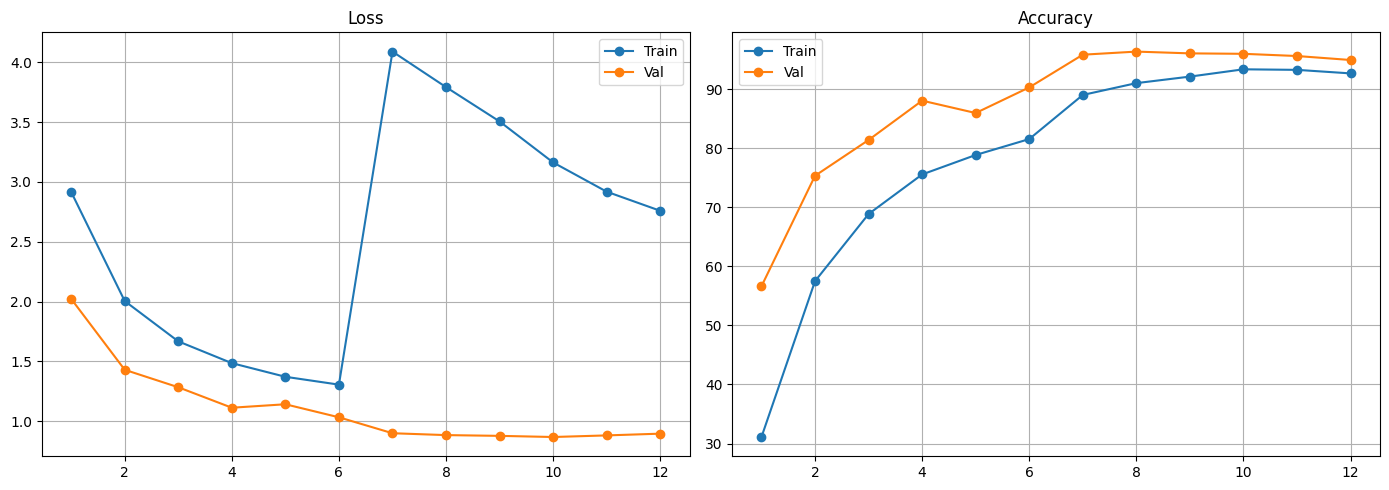

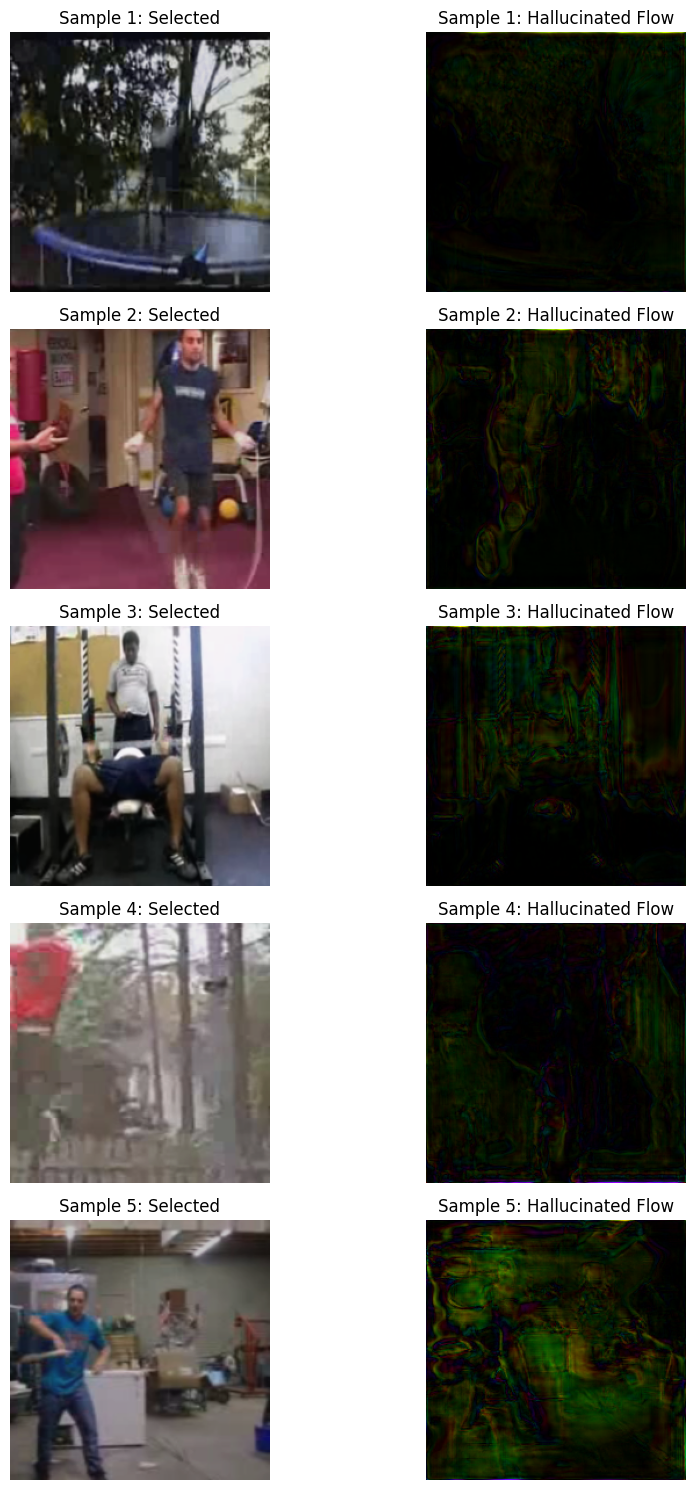

In [31]:
# running everything
if __name__ == "__main__":
    trained_model, val_loader, history_data = run_training_pipeline_full()

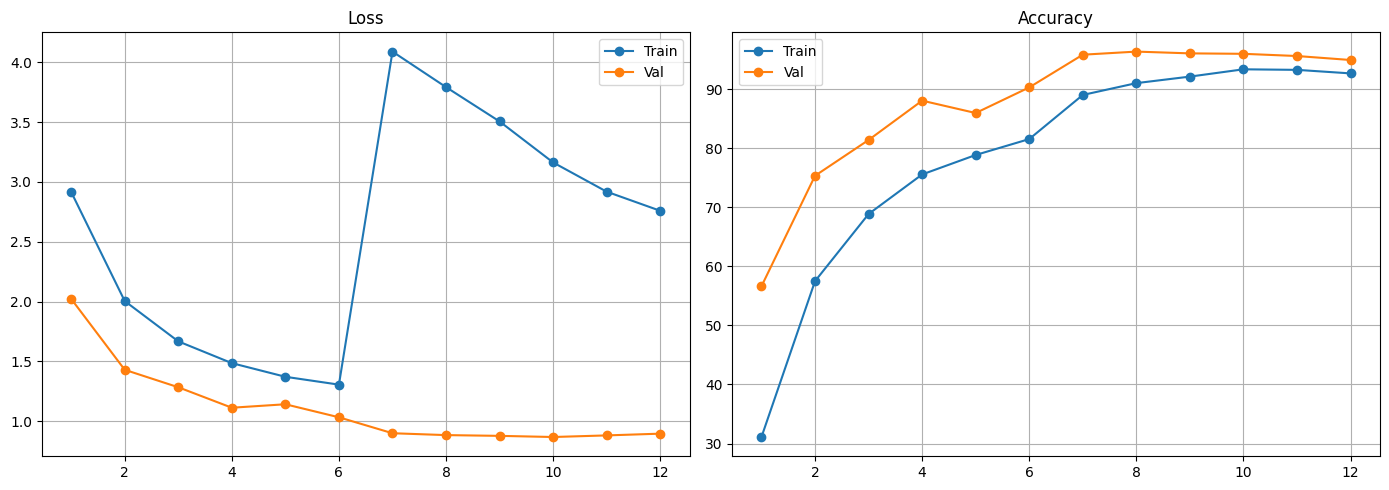

<Figure size 640x480 with 0 Axes>

In [36]:
visualize_training_curves(history_data)